<a href="https://colab.research.google.com/github/camilus77/Maritime-Vessel-Detection/blob/main/classification_of_ship_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computer Vision Hackathon

## Problem Statement

Ship or vessel detection has a wide range of applications, in the areas of maritime safety (Rosnani et al., 2022),  fisheries management, marine pollution, defence and maritime security, protection from piracy, illegal migration, etc (Agastia, 2021; Buegar et al., 2019).

Keeping this in mind, a Governmental Maritime and Coastguard Agency is planning to deploy a computer vision based automated system to identify ship type only from the images taken by the survey boats. You have been hired as a consultant to build an efficient model for this project.

#### Dataset Description
There are 6252 images in train and 2680 images in test data. The categories of ships and their corresponding codes in the dataset are as follows -

There are 5 classes of ships to be detected which are as follows: <br>

1: Cargo <br>
2: Military <br>
3: Carrier <br>
4: Cruise <br>
5: Tankers

Variable	| Definition
--- | ---
image	| Name of the image in the dataset (ID column)
category |	Ship category code
<br>
#### Evaluation Metric
The Evaluation metric for this competition is weighted F1 Score.

#### Misc Rules
- Use of external dataset is not allowed, however, transfer learning can be used to build the solution

# Libraries


In [3]:
import os

import numpy as np
import pandas as pd
from numpy.random import seed
seed(2019)


#visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import gc
import cv2

#sklearn and machine learning
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import f1_score, confusion_matrix

import tensorflow
from tensorflow.keras.utils import load_img, img_to_array, array_to_img
from keras import callbacks
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
tensorflow.random.set_seed(2019) 
#avoid ugly warnings
import warnings
warnings.filterwarnings('ignore')

#mounr drive for colab
from google.colab import drive
drive.mount('/content/drive')



# Exploratory Data Analysis

In [15]:
# define the path for loading .jpg images
path = "/content/drive/MyDrive/ship_classifer_Dataset train/images"

loc = '/content/drive/MyDrive/ship_classifer_Dataset train/train.csv'
#train_files = pd.read_html(url, dtype={'image': 'object', 'category': 'int8'})

train_files = pd.read_csv(loc)#, dtype={'image': 'object', 'category': 'int8'})
                       
test_files = pd.read_csv('/content/drive/MyDrive/ship_classifer_Dataset train/test_ApKoW4T.csv')

In [7]:
#lets have a peek at the training and testing dataset
print(train_files.head())
print(test_files.head())

         image  category
0  2823080.jpg         1
1  2870024.jpg         1
2  2662125.jpg         2
3  2900420.jpg         3
4  2804883.jpg         2
         image
0  1007700.jpg
1  1011369.jpg
2  1051155.jpg
3  1062001.jpg
4  1069397.jpg


No missing values.

Now let us create an encoding dictionary for our ship


In [8]:
# encoding dictionary 
ship = {'Cargo': 1, 
        'Military': 2, 
        'Carrier': 3, 
        'Cruise': 4, 
        'Tankers': 5}

# let us now reverse the ship type dictionary and create our test labels (to aid interpretability)
ship = dict([[v,k] for k,v in ship.items()])

train_files['ship'] = train_files['category'].map(ship).astype('category')
labels = list(train_files['ship'].unique())

Lets get visual knowledge of the number of ships in our dataset

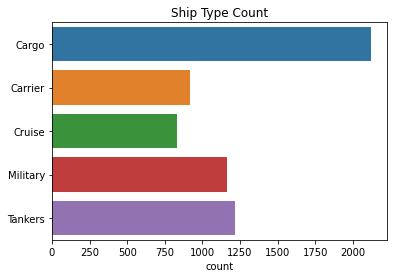

2638

In [9]:
plt.title('Ship Type Count')
sns.countplot(y=train_files['ship'].values)
plt.show()
gc.collect()

We now check for inbalance in our dataset. Remember that a skewed dataset produces biased results

In [10]:
#Unnormalized
train_files['ship'].value_counts(normalize=False)

Cargo       2120
Tankers     1217
Military    1167
Carrier      916
Cruise       832
Name: ship, dtype: int64

In [11]:
#normalized
train_files['ship'].value_counts(normalize=True)

Cargo       0.339091
Tankers     0.194658
Military    0.186660
Carrier     0.146513
Cruise      0.133077
Name: ship, dtype: float64

Since there are class imbalances in training set, we will need to display a confusion matrix visualize to where the neural network classifier is having trouble. We will also stratify train_test_split in order to maintain the class distributions in both train and test.

# Encode Train Labels

In [12]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(dtype='int8', sparse=False)
y_train = ohe.fit_transform(train_files['category'].values.reshape(-1,1))

# Load Train/Test Files

Considering that most pre-trained models normaly have specific input dimensions, it is necessary to set target size such that it matches the input shape of the pre-trained model. 

In [13]:

def load(what='train', target_size=(224,224)):
    array = []
    if what =='train':
        for file in tqdm(train_files['image'].values):
            img = load_img(os.path.join(path, file), target_size=target_size)
            img = img_to_array(img)/255. # normalize image tensor
            array.append(img)
    elif what =='test':
        for file in tqdm(test_files['image'].values):
            img = load_img(os.path.join(path, file), target_size=target_size)
            img = img_to_array(img)/255. # normalize image tensor
            array.append(img)
    gc.collect()
    return np.asarray(array)

Now that that has been done, let us load the train and test data

In [16]:
# Load Train and Test
X_train = load()
test = load('test')

print(f'train shape: {X_train.shape}\n test shape: {test.shape}')
print(f'test shape: {test.shape}')

  0%|          | 3/6252 [00:00<23:22,  4.46it/s]


FileNotFoundError: ignored

# View Some Train Images

In [ ]:
# visualize the top 28 train images
plt.figure(figsize=(12,24))

for i in range(1,29):
    plt.subplot(7,4,i)
    plt.title(f'{train_files["ship"].values[i]}')
    plt.imshow(X_train[i])
    plt.axis('off')
plt.show()
gc.collect()

# View Some Test Images

In [ ]:
# visualize the top 28 test images
plt.figure(figsize=(12,24))

for i in range(1,29):
    plt.subplot(7,4,i)
    plt.imshow(test[i])
    plt.axis('off')
plt.show()
del test # free up space for training
gc.collect()

Images in color and black and white are combined. Old pictures have been used in some of the photographs. Some pictures show smoke or steam rising from smokestacks. Multiple ships can be seen in certain pictures. Some have clouds, while others have a variety of background scenery. Some of them include a lengthwise display, while others feature a ship's front end. There are some low-contrast photos.
We must undertake data augmentation to produce a more robust training set for our neural network in order to solve some of these issues, such as grayscale, rotation, noise, etc. This might improve generalization to the testing dataset and, to some extent, prevent the Neural network from overfitting.

It is impossible to know how many edge cases there are by just looking at the top 28 ship photos from train and test, but at first sight, train and test seem to be rather uniform. In other words, unless you overfit the model, validation results should correspond to test scores.

For each epoch, need to guage model performance using the f1 score. We will create a custom call back fuction to the effect
We need to create a custom callbacks function that calculates f1 score after every epoch to gauge model performance.

In [17]:
class printf1(callbacks.Callback):
    def __init__(self, X_train, y_train):
        super(printf1, self).__init__()
        self.bestf1 = 0
        self.X_train = X_train
        self.y_train = y_train
        
    def on_epoch_end(self, epoch, logs={}):
        pred = np.argmax(self.model.predict(np.array(self.X_train)), axis=1)
        f1 = f1_score(np.argmax(self.y_train, axis=1), pred, average='weighted')
        print("Train F1 Score: {:.4f}".format(f1))
        pred = np.argmax(self.model.predict(self.validation_data[0]), axis=1)
        f1 = f1_score(np.argmax(self.validation_data[1], axis=1), pred, average='weighted')
        print("Valid F1 Score: {:.4f}".format(f1))
        return

In [ ]:
# to plot training/validation history object
def plt_dynamic(x, vy, ty, ax, colors=['b'], title=''):
    ax.plot(x, vy, 'b', label='Validation Loss')
    ax.plot(x, ty, 'r', label='Train Loss')
    plt.legend()
    plt.grid()
    plt.title(title)
    fig.canvas.draw()
    plt.show()
    gc.collect()

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=(6,6))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=0)

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()
    gc.collect()

# Load Pre-trained network and weights (Xception)
Utilize Keras pre-trained model and weights for faster and more accurate image classification models. Weights were loaded from training on Imagenet dataset.

In [ ]:
# make sure internet is enabled in the settings tab to the right
# do not include the last Fully Connected(FC) layer
from keras.applications.xception import Xception
model = Xception(include_top=False, input_shape=(224,224,3))

In [ ]:
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D

x = GlobalAveragePooling2D()(model.output)
#x = Dense(6, activation='relu')(x)
output = Dense(5, activation='softmax')(x)

# define new model
model = Model(model.inputs, output)
model.save('model.hdf5')
#model.summary()

In [ ]:
# visualize the Xception model architecture
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model).create(prog='dot', format='svg'))

# Fine-tune Entire Pre-trained Xception Model

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, 
                                                    stratify=y_train,
                                                    random_state=2019,
                                                    test_size=0.2)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
gc.collect()

It was essential to alter (augment) the current image collection using a data generator due to paucity of data given. Care must however be taken as data augmentation could harm or improve model performance. Consideration of data augmentation must be done case-by-case. This means that adding a vertical flip when none of the ships are turned upside-down will probably make the model less generalizable to test data.


In [ ]:
# use ImageDataGenerator to augment training data
from keras.preprocessing.image import ImageDataGenerator
batch_size = 8
epochs = 50

# make sure to keep learning rate low when fine-tuning
model.compile(loss='categorical_crossentropy', metrics=['accuracy'],
              optimizer=adam(lr=0.0001))

datagen = ImageDataGenerator(rotation_range=45, 
                             horizontal_flip=True, 
                             width_shift_range=0.5, 
                             height_shift_range=0.5, 
                             dtype='float32')

datagen.fit(X_train, augment=True, rounds=1, seed=2019)
train_generator = datagen.flow(X_train, y_train, 
                               batch_size=batch_size, 
                               seed=2019)

f1 = printf1(X_train, y_train)
cp = ModelCheckpoint('best.hdf5', monitor='val_loss', save_best_only=True)
annealer = LearningRateScheduler(lambda x: 1e-4 * 0.95 ** x)

history = model.fit_generator(generator=train_generator, 
                              steps_per_epoch=len(X_train)/batch_size, 
                              validation_data=[X_test, y_test], 
                              callbacks=[cp,f1,annealer],
                              epochs=epochs)

In [ ]:
# printout competition metric - F1 score 
true = np.argmax(y_test, axis=1)
best = load_model('best.hdf5')
valid_pred_best = np.argmax(best.predict(X_test), axis=1)
best_f1_score = f1_score(true, valid_pred_best, average="weighted")
print(f'Best model weighted F1 Score: {best_f1_score:.4f}')

valid_pred = np.argmax(model.predict(X_test), axis=1)
f1_score = f1_score(true, valid_pred, average="weighted")
print(f'weighted F1 Score: {f1_score:.4f}')

# visualize training loss
fig, ax = plt.subplots(1,1)
vy = history.history['val_loss']
ty = history.history['loss']
ax.set_xlabel('Epoch')
x = list(range(1,epochs+1))
ax.set_ylabel('Categorical Crossentropy Loss')
plt_dynamic(x,vy,ty,ax, title='Training History - Xception')

#plot confusion matrix
plot_confusion_matrix(true, valid_pred, normalize=True, 
                      classes=labels, title='Confusion Matrix')


From the confusion matrix here, it seems that our network is mixing up Cargoes and Tankers. There is also a bit of overfitting - even though this does not seem large enough to hurt our predictions. 

# Make Test Predictions

In [ ]:
test = load('test')
sub = pd.read_csv('../input/sample_submission_ns2btKE.csv')

# use the better performing model
if best_f1_score >= f1_score:
    sub['category'] = np.argmax(best.predict(test), axis=1) + 1
else:
    sub['category'] = np.argmax(model.predict(test), axis=1) + 1 
sub.to_csv('submission.csv', index=False)
sub.head()

In [ ]:
sub['category'].map(ship).value_counts(normalize=True)